In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.io import loadmat as loadmat

In [11]:
import ipywidgets as widgets # Loads the Widget framework.
from IPython.core.magics.namespace import NamespaceMagics # Used to query namespace.

# For this example, hide these names, just to avoid polluting the namespace further
get_ipython().user_ns_hidden['widgets'] = widgets
get_ipython().user_ns_hidden['NamespaceMagics'] = NamespaceMagics

class VariableInspectorWindow(object):
    instance = None

    def __init__(self, ipython):
        """Public constructor."""
        if VariableInspectorWindow.instance is not None:
            raise Exception("""Only one instance of the Variable Inspector can exist at a
                time.  Call close() on the active instance before creating a new instance.
                If you have lost the handle to the active instance, you can re-obtain it
                via `VariableInspectorWindow.instance`.""")

        VariableInspectorWindow.instance = self
        self.closed = False
        self.namespace = NamespaceMagics()
        self.namespace.shell = ipython.kernel.shell

        self._box = widgets.Box()
        self._box.layout.overflow_y = 'scroll'
        self._table = widgets.HTML(value = 'Not hooked')
        self._box.children = [self._table]

        self._ipython = ipython
        self._ipython.events.register('post_run_cell', self._fill)

    def close(self):
        """Close and remove hooks."""
        if not self.closed:
            self._ipython.events.unregister('post_run_cell', self._fill)
            self._box.close()
            self.closed = True
            VariableInspectorWindow.instance = None

    def _fill(self):
        """Fill self with variable information."""
        values = self.namespace.who_ls()
        self._table.value = '<div class="rendered_html jp-RenderedHTMLCommon"><table><thead><tr><th>Name</th><th>Type</th><th>Value</th></tr></thead><tr><td>' + \
            '</td></tr><tr><td>'.join(['{0}</td><td>{1}</td><td>{2}'.format(v, type(eval(v)).__name__, str(eval(v))) for v in values]) + \
            '</td></tr></table></div>'

    def _ipython_display_(self):
        """Called when display() or pyout is used to display the Variable
        Inspector."""
        self._box._ipython_display_()
        
inspector = VariableInspectorWindow(get_ipython())

In [71]:
# Loading LFP data from a MAT file.
filepath = 'PFC_Data/ar090313_1_a1_Vstim_100_850_ms.mat'
pfc_data = loadmat(filepath, mdict=None)
response=pfc_data['unit'][0][0][0]

In [65]:
# Resample: Sum up the spikes in each sr samples
def downsample(sigs, sr):
    new_len = int(sigs.shape[1]/sr)
    new_sigs = np.zeros([sigs.shape[0], new_len], dtype=sigs.dtype)
    for i in range(new_len):
        new_sigs[:, i] = np.sum(sigs[:, sr*i:sr*(i+1)], axis=1)
    return new_sigs

In [72]:
sr = 50
resp = downsample(response, sr) # Resample
# Calculate Functional Connectivity
fc1 = np.corrcoef(resp)


/N/soft/rhel6/anaconda3/4.4.0/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/N/soft/rhel6/anaconda3/4.4.0/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


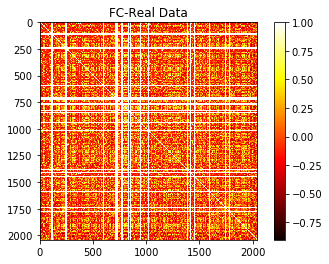

In [83]:
plt.imshow(fc1, cmap='hot')
plt.colorbar()
plt.title('FC-Real Data')

In [82]:
inspector

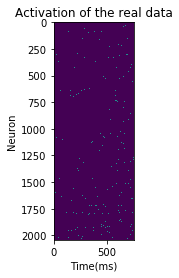

In [86]:
ax=plt.axes()
plt.imshow(response)
ax.set_xlabel('Time(ms)')
ax.set_ylabel('Neuron')
ax.set_title('Activation of the real data')